<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Topic Modeling
## *Data Science Unit 4 Sprint 1 Assignment 4*

Analyze a corpus of Amazon reviews from Unit 4 Sprint 1 Module 1's lecture using topic modeling: 

- Fit a Gensim LDA topic model on Amazon Reviews
- Select appropriate number of topics
- Create some dope visualization of the topics
- Write a few bullets on your findings in markdown at the end
- **Note**: You don't *have* to use generators for this assignment

In [1]:
#Start Here

# topic modeling
# documentation w/ skitlearn
# represent doc as vector (Tdidf) query base on similarity
# tokenize doc (spaCy)

In [4]:
import pandas as pd
import numpy as np
import gensim
import os
import re

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora

from gensim.models.ldamulticore import LdaMulticore

In [5]:
# remove additional words from token
STOPWORDS = set(STOPWORDS).union(set(['said', 'mr', 'mrs']))

# 1) Python - ''.split
# 2) Spacy - lemmas from doc
# 3) Gensim - simple_preprocess
def tokenize(text):
    return [token for token in simple_preprocess(text) if token not in STOPWORDS]

In [25]:
df = pd.read_csv('data/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv')
df.head()

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht..."
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht..."
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,"https://www.barcodable.com/upc/841710106442,ht..."
3,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson,"https://www.barcodable.com/upc/841710106442,ht..."
4,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda,"https://www.barcodable.com/upc/841710106442,ht..."


In [27]:
df['tokens_text'] = df['reviews.text'].apply(tokenize)

In [29]:
# A Dictionary Representation of all the words in our corpus
id2word = corpora.Dictionary(df['tokens_text'])

In [30]:
# amount of memory it's consuming
import sys
sys.getsizeof(id2word)

56

In [31]:
len(id2word.keys())

9620

In [32]:
# Let's remove extreme values from the dataset
id2word.filter_extremes(no_below=20, no_above=0.85)

In [33]:
len(id2word.keys())

1573

In [ ]:
[text for text in df['tokens_text']]

In [37]:
# a bag of words(bow) representation of our corpus
# Note: we haven't actually read any text into memory here
# Although abstracted away - tokenization IS happening in the doc_stream f(x)
corpus = [id2word.doc2bow(text) for text in df['tokens_text']]

In [38]:
lda = LdaMulticore(corpus=corpus,
                   id2word=id2word,
                   random_state=723812, # doesn't really work
                   num_topics = 15, # amount of clusters
                   passes=10, # times data go through the algorithm
                   workers=8 # n_jobs
                  )

In [40]:
lda.print_topics()

[(0,
  '0.094*"kids" + 0.058*"tablet" + 0.055*"great" + 0.020*"use" + 0.018*"apps" + 0.018*"lots" + 0.017*"love" + 0.015*"amazon" + 0.013*"lot" + 0.011*"good"'),
 (1,
  '0.255*"great" + 0.073*"price" + 0.058*"product" + 0.023*"works" + 0.021*"love" + 0.019*"deal" + 0.015*"music" + 0.014*"tablet" + 0.012*"use" + 0.012*"reading"'),
 (2,
  '0.071*"good" + 0.045*"works" + 0.044*"work" + 0.044*"tablet" + 0.031*"google" + 0.030*"store" + 0.029*"great" + 0.026*"apps" + 0.024*"play" + 0.023*"amazon"'),
 (3,
  '0.044*"like" + 0.037*"tablet" + 0.035*"battery" + 0.033*"life" + 0.024*"good" + 0.023*"money" + 0.022*"ok" + 0.017*"buy" + 0.013*"amazon" + 0.012*"time"'),
 (4,
  '0.132*"batteries" + 0.046*"long" + 0.045*"good" + 0.043*"price" + 0.035*"great" + 0.029*"work" + 0.021*"brand" + 0.019*"buy" + 0.017*"brands" + 0.016*"time"'),
 (5,
  '0.054*"use" + 0.052*"tablet" + 0.042*"easy" + 0.022*"love" + 0.022*"size" + 0.021*"perfect" + 0.020*"books" + 0.017*"screen" + 0.016*"movies" + 0.015*"apps"'),


In [44]:
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda.print_topics()]
topics = [' '.join(t[0:5]) for t in words]
for n, t in enumerate(topics): 
    print(f'{n+1}. {t}')

1. kids tablet great use apps
2. great price product works love
3. good works work tablet google
4. like tablet battery life good
5. batteries long good price great
6. use tablet easy love size
7. great tablet value loves good
8. amazon device screen use happy
9. tablet great buy amazon screen
10. nice good tablet like easy
11. bought gift christmas purchased loves
12. old tablet year loves games
13. batteries battery amazon use brand
14. good price quality amazon tablet
15. kindle reading read light love


In [39]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda, corpus, id2word)

C:\Users\George\.virtualenvs\DS-Unit-4-Sprint-1-NLP-Y8VMajW9\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
12     0.230457  0.070092       1        1  12.035154
4      0.282375 -0.071318       2        1  11.769310
11    -0.203222  0.024451       3        1  10.474396
14     0.014847  0.160310       4        1   9.213084
5     -0.149798  0.060107       5        1   7.033529
10    -0.134247  0.065158       6        1   6.502728
13     0.079594 -0.047215       7        1   5.387971
9     -0.021471  0.010472       8        1   5.361918
1     -0.028563 -0.183146       9        1   5.123236
7      0.024347  0.141732      10        1   4.878903
0     -0.048687 -0.060542      11        1   4.773802
2      0.032932 -0.083132      12        1   4.658144
8     -0.054088  0.030652      13        1   4.575377
6     -0.114167 -0.155127      14        1   4.119109
3      0.089691  0.037506      15        1   4.093346, topic_info=     Category         Freq       Term        Total  loglift  logprob
19    Default  9011.000000      great  9011.000000  30.0000  30.0000
16    Default  7628.000000  batteries  7628.000000  29.0000  29.0000
31    Default  5676.000000       good  5676.000000  28.0000  28.0000
175   Default  2587.000000       kids  2587.000000  27.0000  27.0000
1336  Default  7120.000000     tablet  7120.000000  26.0000  26.0000
...       ...          ...        ...          ...      ...      ...
337   Topic15    59.502983      child   494.939178   1.0774  -5.2881
17    Topic15    58.371593     better  1454.277466  -0.0196  -5.3073
93    Topic15    57.878407        got  1245.797241   0.1266  -5.3158
86    Topic15    59.598083        use  4510.272949  -1.1307  -5.2865
16    Topic15    57.654316  batteries  7628.898438  -1.6894  -5.3197

[960 rows x 6 columns], token_table=      Topic      Freq Term
term                      
53        1  0.660822   aa
53        2  0.311213   aa
53        4  0.002021   aa
53        7  0.004042   aa
53        8  0.002021   aa
...     ...       ...  ...
1496      4  0.021384  äôs
1496      5  0.662909  äôs
1496      6  0.138997  äôs
1496      8  0.053460  äôs
1496     11  0.021384  äôs

[5003 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 5, 12, 15, 6, 11, 14, 10, 2, 8, 1, 3, 9, 7, 4])

# Selecting the Number of Topics (Learn)
<a id="#p4"></a>

In [50]:
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, path, limit, start=2, step=3, passes=5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    path : path to input texts
    limit : Max num of topics
    passes: the number of times the entire lda model & coherence values are calculated

    Returns:
    -------
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    coherence_values = []
    
    tokens = list(df['tokens_text'])
    
    for iter_ in range(passes):
        for num_topics in range(start, limit, step):
            stream = df['tokens_text']
            model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, workers=4)
            coherencemodel = CoherenceModel(model=model,dictionary=dictionary,corpus=corpus, coherence='u_mass')
            coherence_values.append({'pass': iter_, 
                                     'num_topics': num_topics, 
                                     'coherence_score': coherencemodel.get_coherence()
                                    })

    return coherence_values

In [51]:
# Can take a long time to run.
coherence_values = compute_coherence_values(dictionary=id2word,
                                            corpus=corpus, 
                                            path=df['tokens_text'], 
                                            start=2, 
                                            limit=40, 
                                            step=6,
                                            passes=40)

In [52]:
topic_coherence = pd.DataFrame.from_records(coherence_values)

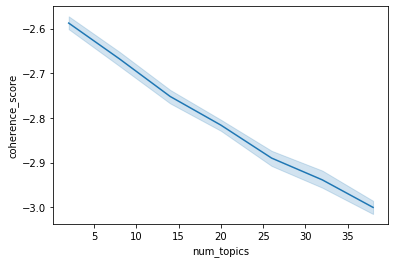

In [54]:
import seaborn as sns

sns.lineplot(x="num_topics", y="coherence_score", data=topic_coherence);

## Stretch Goals

* Incorporate Named Entity Recognition in your analysis
* Incorporate some custom pre-processing from our previous lessons (like spacy lemmatization)
* Analyze a dataset of interest to you with topic modeling